## L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stopwords. The code is implemented as a class, TopicModel, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$)<br>
Sum up $\mathbf{z}$ to $\mathbf{n}$, the topic count vector of length ($K$)<br>

for $g \leftarrow 1$ __to__ _no_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =- 1, $n^{(d)}_{d_i,z_i}$ =- 1, $n_{z_i}$ =- 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ =+ 1, $n^{(d)}_{d_i,z_i}$ =+ 1, $n_{z_i}$ =+ 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [77]:
import numpy, random, scipy.special, math
import matplotlib.pyplot as plt

class MyGibbs():
    
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics))
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics))
        self.topic_totals = numpy.zeros(self.num_topics)
        self.doc_totals = numpy.zeros(self.num_docs)
        
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = list(map(lambda x: random.randrange(self.num_topics), doc['tokens']))
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for i in range(doc_length):
                token = doc['tokens'][i]
                topic = doc['topics'][i]
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
    
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stoplist:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.doc_snippets.append(line[:200])
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
    
    def __init__(self,
                 num_topics,
                 docs_file_name,
                 stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.doc_snippets = []
        self.docs = []
        ## Prepare list of stopwords
        self.stoplist = dict()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stoplist[word] = 1
        self.read_documents(docs_file_name)
        self.initialize_matrices()
    
    def print_topics(self, j):
        for topic in  range(self.num_topics) :
            print('Topic {}'.format(topic))
            indices_sorted = numpy.argsort(self.term_topics[:,topic])
            top_j = indices_sorted[-j:]
            res = []
            for ind in top_j :
                res.append(self.vocab[ind])
            print(res)
    
    def make_draw(self, alpha, beta):
        """Makes a single draw from the posterior distribution in an MCMC fashion."""
        for doc_id in range(self.num_docs) : # iterate through all the tokens
            doc = self.docs[doc_id]
            for n, word in enumerate(doc['tokens']) :
                zi = doc['topics'][n]
                
                # remove current topic indicator from nw, nd and n
                self.term_topics[word][zi] -= 1
                self.doc_topics[doc_id][zi] -= 1
                self.topic_totals[zi] -= 1

                p = numpy.zeros(self.num_topics)
                for k in range(self.num_topics) :
                    # compute the unnormalized probability of each topic indicator
                    p[k] = (alpha + self.doc_topics[doc_id][k])*(beta+self.term_topics[word][k])/(self.num_topics*beta+self.topic_totals[k])

                # Sample the topic indicator
                p = p/sum(p)
                new_zi = numpy.argmax(numpy.random.multinomial(10, p))

                # Add the new topic indicator zi
                doc['topics'][n] = new_zi
                self.term_topics[word][new_zi] += 1
                self.doc_topics[doc_id][new_zi] += 1
                self.topic_totals[new_zi] += 1
                
    def compute_logprob(self, alpha, beta):
        """Computes the log marginal posterior."""
        log = 0
        log += self.num_topics*scipy.special.gammaln(self.num_terms*beta) # 1.
        log -= self.num_topics*self.num_terms*scipy.special.gammaln(beta) # 2.
        
        # 3.
        temp = 0
        for i in range(self.num_topics) :
            for j in range(self.num_terms) :
                temp += scipy.special.gammaln(self.term_topics[j][i] + beta)
        log += temp
        
        # 4.
        temp = 0 
        for i in range(self.num_topics) :
            temp2 = 0
            for j in range(self.num_terms) :
                temp2 += self.term_topics[j][i]
            temp += scipy.special.gammaln(temp2+beta)
        log -= temp
        
        log += self.num_docs*scipy.special.gammaln(self.num_topics*alpha) # 5.
        log -= self.num_docs*self.num_topics*scipy.special.gammaln(alpha) # 6.
        
        # 7.
        temp = 0
        for i in range(self.num_docs) :
            for j in range(self.num_topics) :
                temp += scipy.special.gammaln(self.doc_topics[i][j] + alpha)
        log += temp
        
        # 8.
        temp = 0 
        for i in range(self.num_docs) :
            temp2 = 0
            for j in range(self.num_topics) :
                temp2 += self.doc_topics[i][j]
            temp += scipy.special.gammaln(temp2+alpha)
        log -= temp
        
        return log
    
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations):
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
    
    def run2(self, threshold = 100, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        previous = 0
        current = 2*threshold
        iteration = 0
        while math.fabs(previous-current) > threshold :
            iteration += 1
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            previous = current
            current = logprob
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def plot(self):
        plt.plot(range(len(self.logprobs)), self.logprobs)
        
    def new_speech(self, alpha = 0.5, N = 20) :
        speech = []
        theta = numpy.random.dirichlet(alpha = [0.5] * self.num_topics)
        #print(theta)
        for w in range(N) :
            z = numpy.random.choice(10, 1, p = list(theta))[0]
            #print(z)
            prob_z = self.term_topics[:,z]/sum(self.term_topics[:,z])
            word = numpy.random.choice(self.num_terms, 1, p = prob_z)
            
            for voc in self.vocab_ids.keys():
                if self.vocab_ids[voc] == word :
                    speech.append(voc)
        return speech    

Implement the make_draw function above. You should get behavior very similar to the results from calling the parent class.

In [74]:
model = MyGibbs(10, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(10)

Read 2898 documents with a total of 8695 terms
iteration 0, -675095.4192150987
iteration 1, -631002.9023275846
iteration 2, -617420.6811219492
iteration 3, -611422.4813678896
iteration 4, -607572.9724700216
iteration 5, -605328.851956223
iteration 6, -603461.5203424115
iteration 7, -601997.9925551869
iteration 8, -600732.4692501829
iteration 9, -599452.5095325429


### 2. Top terms
Implement the print_topics function to extract the top j largest counts in n (w) by row. This is the most probable word types in each topic.

In [75]:
model.print_topics(10)

Topic 0
['american', 'economic', 'work', 'people', 'congress', 'year', 'government', 'years', 'america', 'world']
Topic 1
['world', 'work', 'make', 'years', 'american', 'government', 'year', 'congress', 'america', 'people']
Topic 2
['americans', 'freedom', 'country', 'time', 'budget', 'american', 'world', 'year', 'america', 'people']
Topic 3
['income', 'insurance', 'school', 'federal', 'million', 'years', 'care', 'children', 'americans', 'health']
Topic 4
['increase', 'full', 'jobs', 'water', 'research', 'special', 'power', 'democratic', 'technology', 'tax']
Topic 5
['social', 'civil', 'days', 'reduce', 'back', 'space', 'good', 'god', 've', 'bill']
Topic 6
['science', 'give', 'll', 'nato', '2', 'housing', 'business', 'community', 'welfare', 'crime']
Topic 7
['promote', 'teachers', 'parents', 'bill', 'students', 'communities', 'century', 'schools', 'tonight', 'children']
Topic 8
['congress', 'speaker', 'members', 'fellow', 'americans', 'citizens', 'tonight', 'great', 'mr', 'president']


### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

Read 2898 documents with a total of 8695 terms
iteration 1, -675401.6484279687
iteration 2, -631667.0932243718
iteration 3, -618369.7846580343
iteration 4, -612200.8435545528
iteration 5, -608413.9158387794
iteration 6, -605709.9808010226
iteration 7, -603734.4216968124
iteration 8, -602240.9068262413
iteration 9, -600973.2918109142
iteration 10, -599947.8100634448
iteration 11, -599280.2653108793
iteration 12, -598662.5038769245
iteration 13, -598040.4752698966
iteration 14, -597482.8447051614
iteration 15, -596902.0787045833
iteration 16, -596336.8920007158
iteration 17, -595865.5999878069
iteration 18, -595339.5099656924
iteration 19, -594963.2399665709
iteration 20, -594571.163290842
iteration 21, -594045.3150933238
iteration 22, -593771.0621449888
iteration 23, -593450.787003555
iteration 24, -593187.2221117987
iteration 25, -592999.3315206352
iteration 26, -592759.1831121934
iteration 27, -592610.3719513294
iteration 28, -592471.1779901799
iteration 29, -592326.3740276417
iterati

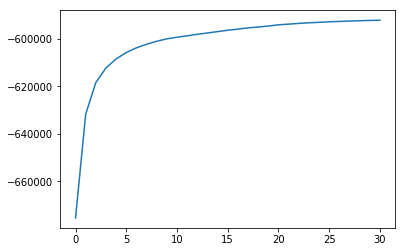

In [78]:
%matplotlib inline
model = MyGibbs(10, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run2()
model.plot()

#### Answer here:

### 4. Simulate a new State of the Union speech

Write a function new_speech in the MyGibbs class to use the estimated values for $\Phi$ from your model (with stopwords removed) to simulate a new State of the Union speech. Start out by simulating $\theta d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [79]:
new_speech = model.new_speech()
print(new_speech)

new_speech2 = model.new_speech(alpha = 0.1)
print(new_speech2)

['5', 'waiting', 'social', 'finally', 'clogged', 'verifiable', 'lot', 'crises', 'results', 'convicted', 'presence', 'make', 'justifiably', 'marshaled', 'serves', 'movement', 'turning', 'established', 'procedures', '1980']
['worldwide', 'emerging', 'human', 'concern', 'zone', 'begin', 'deficit', 'venture', 'dealing', 'opened', 'countries', 'prove', 'welfare', 'digit', 'buying', 'sound', 'schools', 'passage', 'hattiesburg', 'regional']


#### Answer here:

### Bonus assignment:

To get better understanding of the underlying model, you might want to implement your own function to compute the log marginal posterior. If so, implement the compute_logprob function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).